# SCC0287 - Trabalho 2
- Luiz Fernando S. Eugênio dos Santos
- 10892680

## Introdução

No presente projeto, será feito o treinamento de um modelo para o reconhecimento de alguns gestos em libras. O objetivo final é produzir uma etapa do pipeline para uma aplicação de "teclado" por reconhecimento de gestos usando uma câmera com sensor de profundidade. No caso, será usado o sensor *Kinnect* do console de videogame *Xbox 360* da *Microsoft*. 

Também vale comentar que libras conta com gestos que podem ser reconhecidos unicamente por uma posição da mão bem como outros que contém movimento e posições relativas de outras partes do corpo. Por simplicidade, seguiremos a abordagem descrita no paper *Recognition of Static Gestures Applied to Brazilian Sign Language (Libras)* (Bastos, I. et al.), bem como seu dataset coletado. Queremos apenas um alfabeto completo, portanto, para compensar pela falta de algumas letras, estas serão substituídas por outras palavras ao passo que as palavras restantes serão deixadas de lado. 

## Carregando Dataset

In [1]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import io
import os
import mahotas as mt
from skimage.feature import hog
import numpy as np

In [2]:
# Obtendo paths para todas as classes e imagens
PATH = "./Folds_Dataset_Final/"
img_paths = {}
for folder in os.listdir(PATH):
    if (os.path.isdir(PATH+folder)):
        folder_path = PATH+folder
        for c in os.listdir(folder_path):
            if c in img_paths.keys():
                img_paths[c] += [folder_path+"/"+c+"/"+i for i in os.listdir(folder_path+"/"+c)]
            else:
                img_paths[c] = [folder_path+"/"+c+"/"+i for i in os.listdir(folder_path+"/"+c)]

In [3]:
img_paths["X"]

['./Folds_Dataset_Final/Fold3/X/16.PNG',
 './Folds_Dataset_Final/Fold3/X/c4.PNG',
 './Folds_Dataset_Final/Fold3/X/8.PNG',
 './Folds_Dataset_Final/Fold3/X/6.PNG',
 './Folds_Dataset_Final/Fold3/X/c19.PNG',
 './Folds_Dataset_Final/Fold3/X/2.PNG',
 './Folds_Dataset_Final/Fold3/X/18.PNG',
 './Folds_Dataset_Final/Fold3/X/9.PNG',
 './Folds_Dataset_Final/Fold3/X/5.PNG',
 './Folds_Dataset_Final/Fold3/X/c11.PNG',
 './Folds_Dataset_Final/Fold3/X/c15.PNG',
 './Folds_Dataset_Final/Fold3/X/c6.PNG',
 './Folds_Dataset_Final/Fold3/X/14.PNG',
 './Folds_Dataset_Final/Fold3/X/c7.PNG',
 './Folds_Dataset_Final/Fold3/X/0.PNG',
 './Folds_Dataset_Final/Fold3/X/c18.PNG',
 './Folds_Dataset_Final/Fold3/X/12.PNG',
 './Folds_Dataset_Final/Fold3/X/3.PNG',
 './Folds_Dataset_Final/Fold3/X/11.PNG',
 './Folds_Dataset_Final/Fold3/X/c2.PNG',
 './Folds_Dataset_Final/Fold3/X/c16.PNG',
 './Folds_Dataset_Final/Fold3/X/c10.PNG',
 './Folds_Dataset_Final/Fold3/X/c5.PNG',
 './Folds_Dataset_Final/Fold3/X/4.PNG',
 './Folds_Dataset_

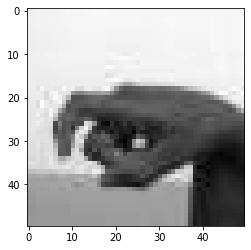

In [4]:
img = rgb2gray(plt.imread("./Folds_Dataset_Final/Fold3/X/16.PNG"))
plt.imshow(img, cmap="gray")
plt.show()

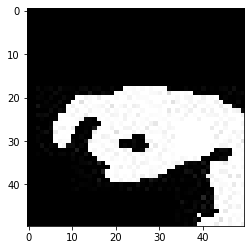

In [5]:
img_mask = rgb2gray(plt.imread("./Folds_Dataset_Final/Fold3/X/c16.PNG"))
plt.imshow(img_mask, cmap="gray")
plt.show()

In [6]:
print(img.shape)

(50, 50)


Entre as classes de letras presentes, faltam as letras $H,J,K$ e $Z$. Vamos utilizar as classes presentes $Casa$, $Junto$, $Pequeno$ e $Verbo$ para substituí-las respectivamente.

In [7]:
img_paths["Z"] = img_paths["Verbo"]
img_paths["K"] = img_paths["Pequeno"]
img_paths["J"] = img_paths["Junto"]
img_paths["H"] = img_paths["Casa"]

In [8]:
# ignoraremos as demais classes
keys = list(img_paths.keys())
for key in keys:
    if (key not in ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']):
        del img_paths[key]

In [9]:
dataset,dataset_mask, dataset_3channel, y = [], [], [], []
for key in img_paths.keys():
    paths = img_paths[key]
    for path in paths:
        path = path.split("/")
        if ('c' not in path[-1]):
            y.append(key)
            image = rgb2gray(plt.imread('/'.join(path)))
            image_mask = rgb2gray(io.imread('/'.join(path[:-1])+'/c'+path[-1]))
            dataset.append(image)
            dataset_mask.append(image_mask)
            dataset_3channel.append(io.imread('/'.join(path)))

## Abordagem Descritores de Textura

Nessa etapa, seguindo o paper *Recognition of Static Gestures Applied to Brazilian Sign Language (Libras)* (Bastos, I. et al.) foram utilizados os descritores de textura Zernike e HOG (*Histogram of Oriented Gradients*), nas imagens em gayscale e binarizadas, respectivamente.

In [10]:
def extract_features(img_gray, img_mask):
    zernike = mt.features.zernike_moments(img_gray, 3)
    fd = hog(img_mask, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2))
    return list(zernike)+list(fd)

In [11]:
X = [extract_features(img, img_mask) for img, img_mask in zip(dataset, dataset_mask)]
print(len(X))

3120


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(X, y, dataset, test_size=0.3, random_state=42)
model = SVC(kernel='rbf', degree=3, gamma='scale', random_state=42)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
print(f"Acurácia: {accuracy_score(y_predict, y_test)}")

Acurácia: 0.9893162393162394


Predição: I
Esperado: I


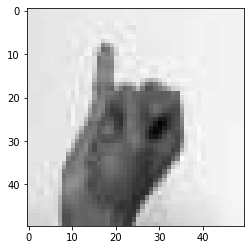

In [13]:
IDX = 442

plt.imshow(data_test[IDX], cmap="gray")
print(f"Predição: {model.predict([X_test[IDX]])[0]}")
print(f"Esperado: {y_test[IDX]}")

In [14]:
# Salvando classificador treinado
from joblib import dump

model = SVC(kernel='rbf', degree=3, gamma='scale', random_state=42)
model.fit(X, y)
dump(model, "libras.joblib")

['libras.joblib']

## Abordagem CNN

Em sequência, uma CNN foi utilizada apenas nas imagens em grayscale para comparação.

In [15]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

y_categorical = to_categorical(LabelEncoder().fit_transform(y))
X_train, X_test, y_train, y_test = train_test_split(dataset_3channel, y_categorical, test_size=0.3, random_state=42)

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

img_width, img_height = 50, 50
nb_train_samples = len(X_train)
nb_test_samples = len(X_test)
epochs = 50
batch_size = 64

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(26))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 22, 22, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                    

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(np.array(X_train), y=np.array(y_train), batch_size=batch_size)
test_generator = test_datagen.flow(np.array(X_test), y=np.array(y_test), batch_size=batch_size)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0.]


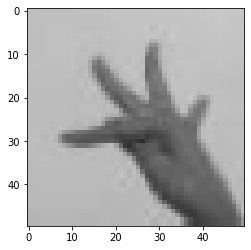

In [18]:
X,Y = train_generator.next()
print(Y[0])
plt.imshow(X[0], cmap='gray')

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_test_samples // batch_size)

<ipython-input-19-3914e9f5457c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
34/34 [==============================] - 3s 79ms/step - loss: 3.2589 - accuracy: 0.0448 - val_loss: 3.2138 - val_accuracy: 0.1049
Epoch 2/50
34/34 [==============================] - 3s 83ms/step - loss: 3.0486 - accuracy: 0.1330 - val_loss: 2.6543 - val_accuracy: 0.2790
Epoch 3/50
34/34 [==============================] - 3s 88ms/step - loss: 2.5701 - accuracy: 0.2519 - val_loss: 2.0779 - val_accuracy: 0.4944
Epoch 4/50
34/34 [==============================] - 4s 105ms/step - loss: 2.1102 - accuracy: 0.3858 - val_loss: 1.5052 - val_accuracy: 0.7165
Epoch 5/50
34/34 [==============================] - 3s 91ms/step - loss: 1.7474 - accuracy: 0.4741 - val_loss: 1.0101 - val_accuracy: 0.7801
Epoch 6/50
34/34 [==============================] - 3s 98ms/step - loss: 1.4981 - accuracy: 0.5453 - val_loss: 0.7988 - val_accuracy: 0.8304
Epoch 7/50
34/34 [==============================] - 4s 103ms/step - loss: 1.3275 - accuracy: 0.5906 - val_loss: 0.6492 - val_accuracy: 0.8705
Epoch 8/50


## Conclusões

Usando os descritores de textura obtivemos uma acurácia de $0.989$ em teste, ao passo que utilizando a rede convolucional foi obtido um score de $0.948$. Isso possivelmente se deve à combinação dos dois descritores, usando a imagem da mão destacada como um conhecimento externo que contribui positivamente no treinamento. 

Na aplicação desenvolvida, foi usado o **Kinnect** contendo um sensor de profundidade, possibilitando a extração das imagens nesse formato de maneira eficiente. Combinado ao menor uso de memória e tempo de execução dessa abordagdem, ela se mostrou mais eficiente em especial para o uso em tempo real.